# 背景削除
## 制作
高田一晴
(2022/5/10)

## はじめに
このノートブックでは PyTorch を用いた 画像加工 -> 背景削除 -> 物体検出 を行うことを目的に画像加工アルゴリズム -> 背景削除モデル の実行をします。また、このノートブックは Google Colaboratory で実行可能です。
実行時間: 約30分

## 引用・参考
 - https://www.kaggle.com/code/leoooo333/background-remove-tutorial
   - ライセンス: Apach2.0
 - https://www.kaggle.com/code/clemchris/pytorch-backfin-convnext-arcface
   - ライセンス: Apach2.0

## 構成
 - 形式: ipynb
 - データセット: Roboflow より [EgoHands Dataset](https://public.roboflow.com/object-detection/hands/1)
   - ライセンス: CC BY 4.0
   - Train画像: 3840枚・Valid画像: 480枚・Test画像: 480枚
 - 言語/フレームワーク: python, PyTorch
 - モデル: U2Net

## プログラム
### 1. Google ドライブのマウント

Google ドライブにマウントし、ファイルへアクセスできるようにします。

In [1]:
# Google ドライブにマウントし、ファイルへアクセスする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. データセットのダウンロード
Roboflow の [EgoHands Dataset](https://public.roboflow.com/object-detection/hands/1)よりオープンソースの画像を '/content/drive/MyDrive/datasets/' 下にダウンロードします。

この画像は [本家 EgoHands dataset](http://vision.soic.indiana.edu/projects/egohands/)を物体検出用にアノテーションを行ったものです。
形式は coco format に準拠しています。


### 3. ライブラリインストール 
#### U2Netのインストール

In [2]:
!git clone https://github.com/shreyas-bk/U-2-Net
    
import sys
sys.path.append('./U-2-Net')

Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Total 520 (delta 0), reused 0 (delta 0), pack-reused 520
Receiving objects: 100% (520/520), 12.39 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (236/236), done.


次に学習済みモデルを[U-2-Net(Github)](https://github.com/xuebinqin/U-2-Net)の
 - u2net.pth (176.3 MB) from [GoogleDrive](https://drive.google.com/file/d/1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ/view?usp=sharing)
 - u2netp.pth (4.7 MB) from [GoogleDrive](https://drive.google.com/file/d/1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy/view?usp=sharing)
 より '/content/drive/MyDrive/model/U2Net' 下にダウンロードします。

### 出力先フォルダの作成
'/content/drive/MyDrive/datasets/EgoHands/output' 下に 'subtraction_train' フォルダを作成します。ここに背景削除後の画像が保存されます

### 4. インポート

In [15]:
# Path関連
from pathlib import Path

# json関連
import json

# 画像全般
import cv2 as cv
from PIL import Image

# グラフ表示
import matplotlib.pyplot as plt

# 行列演算関連
import numpy as np
import pandas as pd

# AI関連
# PyTorch
import torch
from torchvision import transforms, datasets
from torch.autograd import Variable

# AIデータセット関連
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# U2Netモデル関連
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from model import U2NET 
from model import U2NETP

# os関連
import os

# 学習等の進捗状況を可視化するプログレスバー
from tqdm.notebook import tqdm

### 5. Paths

In [4]:
DATA_ROOT_DIR = Path("/") / "content" / "drive" / "MyDrive" / "datasets" / "EgoHands"
TRAIN_DIR = DATA_ROOT_DIR / "train"
VALID_DIR = DATA_ROOT_DIR / "valid"
TEST_DIR = DATA_ROOT_DIR / "test"

### 6. 設定

In [20]:
# 設定
root_out = '/content/drive/MyDrive/datasets/EgoHands/output'# root_out は、処理後の「画像、csv等」のフォルダの場所を指定します。

THRESHOLD = 0.9
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VALID_THERESHOLD = 0.2 # 有効な画像を選別するために area threshold を使用する
UNET2_SMALL = False

### 7. CLAHEの実装

In [6]:
# CLAHE
# ヒストグラムの平坦化
# 画像の明るさの調整
def CLAHE_Convert(origin_input):
    imidx = origin_input['imidx']
    label = origin_input['label']
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(24,32))
    img = np.asarray(origin_input['image'])
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img[:,:,-1] = clahe.apply(img[:,:,-1])
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
    
    return {'imidx':imidx, 'image':img,'label':label}

# BilateralFilter
# エッジを保存した平滑化処理
# ノイズの削除
def BilateralFilter_Convert(origin_input):
    imidx = origin_input['imidx']
    label = origin_input['label']
    img = np.asarray(origin_input['image'])
    img = cv.bilateralFilter(img,5,75,75)
    
    return {'imidx':imidx, 'image':img,'label':label}

# EqualizeHist
# ヒストグラムの平坦化
# 画像の明るさの調整
def EqualizeHist_Convert(origin_input):
    imidx = origin_input['imidx']
    label = origin_input['label']
    img = np.asarray(origin_input['image'])
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img[:,:,-1] = cv.equalizeHist(img[:,:,-1])
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
    
    return {'imidx':imidx, 'image':img,'label':label}

In [7]:
# ノルムの実装
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn

### 8. 背景削除関数

In [8]:
def pred_unet_CLAHE(model, imgs, paths, train=False):
    # SalObjデータセット
    # U-net に用意されているDatasetフォーマット
    salobj_dataset = SalObjDataset(
        img_name_list = imgs, # 画像PATH
        lbl_name_list = [], # ラベル名
        transform = transforms.Compose([
            CLAHE_Convert, 
            RescaleT(320), # 画像サイズ320
            ToTensorLab(flag=0)])) # transforms

    # データローダー
    salobj_dataloader = DataLoader(salobj_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 1)
    
    # モデルをデバイスに
    model.to(DEVICE)
    
    # evalループ。学習済みのU-2-Netを用いている
    error_log = []
    for i, batch in enumerate(salobj_dataloader):
        # model.eval
        model.eval()

        img_batch = batch['image'] # (batch size, channel, row, columns)
        images = img_batch.type(torch.float32) # change torch.double -> torch.float
        images = images.to(DEVICE) 
        # eval実行
        with torch.no_grad():
            d1, d2, d3, d4, d5, d6, d7 = model(images)
        
        predict = d5[:,0,:,:]# (batch size, 1, row, columns)
        predict = normPRED(predict)

        del d1, d2, d3, d4, d5, d6, d7

        # ラベル平滑化
        predict = predict.squeeze()# (batch size, row, columns)
        # cpu上でndarrayを使うため
        predict_np = predict.cpu().numpy()

        # マスク画像 - 閾値を使ってマスクの境界をソフトにしたりシャープにしたりすることができる
        predict_np[predict_np > THRESHOLD] = 1
        predict_np[predict_np <= THRESHOLD] = 0

        # 各画像に対し、
        for j in range(len(predict_np)):
            file = paths[i * BATCH_SIZE + j]
            mask_np = predict_np[j]
            mask = Image.fromarray(mask_np*255).convert('RGB')
            image = Image.open(imgs[i * BATCH_SIZE + j])
            mask = mask.resize((image.width, image.height), resample=Image.BILINEAR)
            back = Image.new("RGB", (image.width, image.height), (255, 255, 255)) # 白背景化
            mask = mask.convert('L')
            im_out = Image.composite(image, back, mask)
            
            mask_rs = np.array(mask)
            
            x,y,w,h = cv.boundingRect (mask_rs)
            ymin = y
            ymax = y + h
            xmin = x
            xmax = x + w
            
            # 無効な画像を "1"(白)領域/矩形領域(白と黒)で選別するために使用されます。
            # 画像が改善してるかチェック。改悪していたらエラーログが出る
            if (x,y,w,h) == (0,0,0,0) or (((mask_rs != 0).sum()) / (w * h)) < VALID_THERESHOLD:
                crop_img = np.array(image)
                error_log.append(file)
                print('Failed:\t', file)
            else:
                im_out_np = np.array(im_out)
                crop_img = im_out_np[ymin:ymax, xmin:xmax]
                crop_img = cv.resize(crop_img, (im_out_np.shape[0], im_out_np.shape[1]), interpolation = cv.INTER_AREA)
            # train/test
            if train:
                cv.imwrite(os.path.join(root_out, 'subtraction_train', file), crop_img)
            else:
                cv.imwrite(os.path.join(root_out, 'subtraction_test', file), crop_img)
    # train/test
    if train:
        pd.DataFrame({'image':error_log}).to_csv(os.path.join(root_out, 'Ignorance_Train_Img.csv'))
    else:
        pd.DataFrame({'image':error_log}).to_csv(os.path.join(root_out, 'Ignorance_Test_Img.csv'))

### 9. モデルインスタンスの設定

In [9]:
# U2NETモデルの作成
if UNET2_SMALL: # 処理がかなり速い。でも精度が落ちる
    model_dir = "/content/drive/MyDrive/model/U2Net/u2netp.pth"  
    net = U2NETP(3,1) 
else:
    model_dir = "/content/drive/MyDrive/model/U2Net/u2net.pth"
    net = U2NET(3,1) 

# GPU or CPU 上にモデルデータを読み込み
if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_dir))
    net.cuda()
else:
    net.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))

# 評価モード
net.eval()

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

### 10. image path 追加用関数

In [10]:
def get_image_path(file_name: str, dir: Path) -> str:
    return f"{dir / file_name}"

### 11. df作成

In [11]:
# jsonファイル読み込み
json_open = open('/content/drive/MyDrive/datasets/EgoHands/train/_annotations.coco.json', 'r')
json_load = json.load(json_open)
# アノテーションデータ読み込み
images = json_load['images']

# df作成
df = pd.DataFrame(images)

# image pathの追加
df["image_path"] = df["file_name"].apply(get_image_path, dir=TRAIN_DIR)

### 12. 実行

In [16]:
image_names = [file for file in df.file_name]
image_path = [file for file in df.image_path]
pred_unet_CLAHE(net, image_path, image_names, train=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Failed:	 JENGA_OFFICE_B_S_frame_1266_jpg.rf.2d8d4c9c617b6002ca09827e89073252.jpg
Failed:	 CHESS_LIVINGROOM_B_S_frame_0527_jpg.rf.2e9522875dc4e86cef432fe22c7bfb2c.jpg
Failed:	 JENGA_LIVINGROOM_S_T_frame_0838_jpg.rf.2e9f91d5c47cf83be1f0d0160825244c.jpg
Failed:	 CHESS_LIVINGROOM_T_H_frame_0025_jpg.rf.2fc91569e237665d74bf794636721ef4.jpg
Failed:	 PUZZLE_LIVINGROOM_H_S_frame_2021_jpg.rf.305b567bdf4b45b8ede3b3a885fe6401.jpg
Failed:	 CHESS_LIVINGROOM_S_B_frame_1194_jpg.rf.3079003a81215a6bb0fab4fe6a762edc.jpg
Failed:	 PUZZLE_OFFICE_B_H_frame_1660_jpg.rf.313e21a115b9836cefead709a91012c8.jpg
Failed:	 JENGA_OFFICE_T_H_frame_1063_jpg.rf.336368057822db0732f3f962a1f7ac6e.jpg
Failed:	 PUZZLE_OFFICE_B_H_frame_2102_jpg.rf.3421ef39c6fd930185aad78ccb953a9c.jpg
Failed:	 PUZZLE_OFFICE_S_T_frame_1747_jpg.rf.357d8a83a676ec68a6fd2d689d65e5c5.jpg
Failed:	 PUZZLE_LIVINGROOM_T_B_frame_1330_jpg.rf.3679c095097957332a8972a316382378.jpg
Failed:	 PUZZLE_LIVINGROOM_T_B_frame_0709_jpg.rf.37ce5fd6eba87f3eb14c86cc42f05aa

### 13. 背景削除後の画像の確認

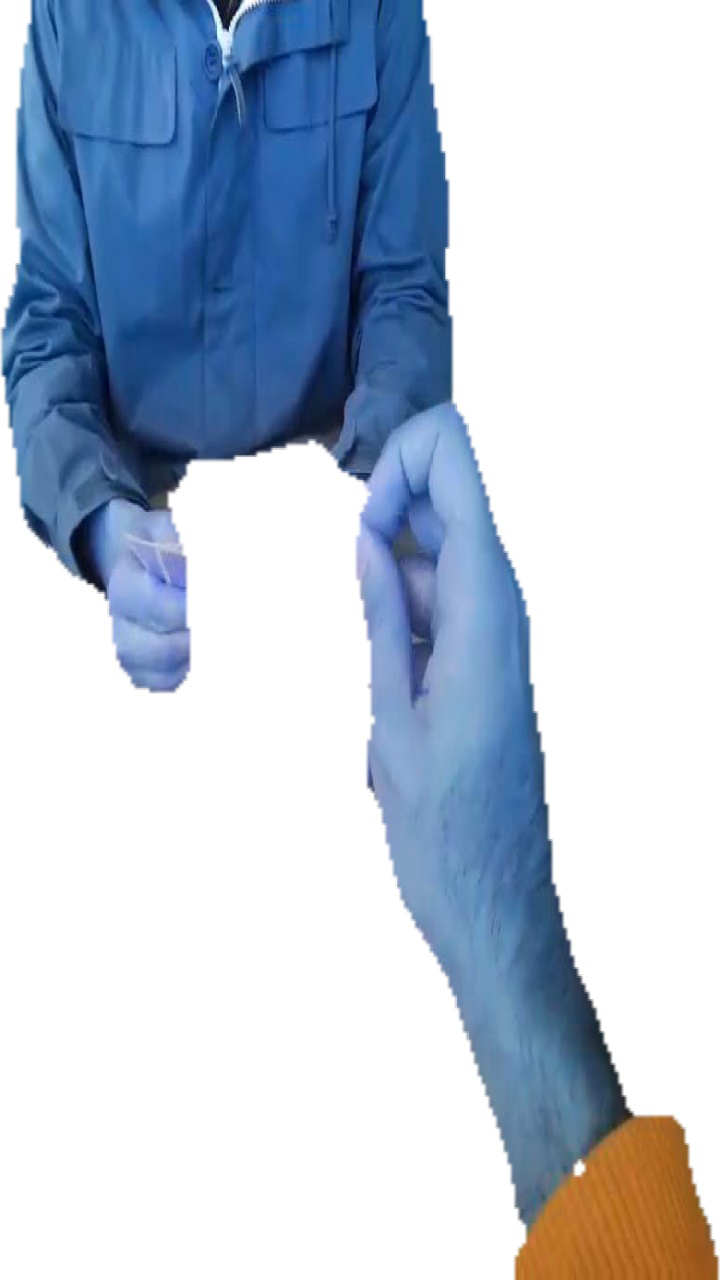

In [19]:
im = Image.open("/content/drive/MyDrive/datasets/EgoHands/output/subtraction_train/CARDS_COURTYARD_H_S_frame_2693_jpg.rf.d0624706d2acc1342c5205043dcade94.jpg")
im